# Relational Conditional Neural Processes (RCNP)

Luigi Acerbi

In this notebook, we introduce **Relational Conditional Neural Processes (ECNPs)** as a proof of concept.

We recall that standard Conditional Neural Processes (CNPs) learn to approximate a distribution over functions rather than approximating just a single function. As a result, at test time CNPs are flexible and can approximate any function from this distribution when provided with a handful of observations. In addition, they learn to estimate the uncertainty of their prediction from the dataset and as the number of observations is increased this uncertainty reduces and the accuracy of their prediction increases.

### Acknowledgments

The sections describing the training data and CNPs are largely based on Shali Jiang's [PyTorch implementation](https://github.com/shalijiang/neural-process) of conditional neural processes, which was in itself built from the [original tensorflow code](https://github.com/deepmind/neural-processes).

# 1D regression task

We start by importing the necessary dependencies. This implementation is based on PyTorch.

In [1]:
import numpy as np
import numpy.random as npr
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda") if USE_CUDA else torch.device("cpu")



We define below some global variables for the notebook.

In [2]:
train_CNP = True
train_RCNP = True

TRAINING_ITERATIONS = int(1e5)
MAX_CONTEXT_POINTS = 30
PLOT_AFTER = int(2e3)

## Training data

A crucial property of CNPs is their flexibility at test time, as they can model a whole range of functions and narrow down their prediction as we condition on an increasing number of context observations. This behaviour is a result of the training regime of CNPs which is reflected in our datasets.
 
Rather than training using observations from a single function as it is often the case in machine learning (for example value functions in reinforcement learning) we will use a dataset that consists of many different functions that share some underlying characteristics. At each iteration we randomly choose one from the dataset and provide some observations from that function for training. For the next iteration we put that function back and pick a new one from our dataset and use this new function to select the training data. This type of dataset (a "dataset of datasets") ensures that our model can't overfit to a single function but rather learns a distribution over functions. This idea of a hierarchical dataset also lies at the core of current meta-learning methods. Examples of such datasets could be:

- Functions describing the evolution of temperature over time in different cities of the world.
- A dataset of functions generated by a motion capture sensor of different humans walking.
- As in this particular example, different functions generated by a Gaussian process (GP) with a specific kernel.

We have chosen GPs for the data generation of this example because they constitute an easy way of sampling smooth curves that share some underlying characteristic (in this case the kernel). Other than for data generation of this particular example neural processes do not make use of kernels or GPs as they are implemented as neural networks.
 

### Data generator

In the following section we provide the code for generating our training and testing sets using a GP to generate a dataset of functions. As we will explain later, CNPs use two subset of points at every iteration: one to serve as the context, and the other as targets. In practise we found that including the context points as targets together with some additional new points helped during training. Our data generator divides the generated data into these two groups and provides it in the correct format.

In [3]:
# The CNP takes as input a `CNPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tensor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)


class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

    Supports vector inputs (x) and vector outputs (y). Kernel is
    mean-squared exponential, using the x-value l2 coordinate distance scaled by
    some factor chosen randomly in a range. Outputs are independent gaussian
    processes. GP hyperparameters are randomly generated in a range.
    """

    def __init__(
        self,
        batch_size,
        max_num_context,
        x_size=1,
        y_size=1,
        l1_logscale=(np.log(0.1),np.log(1.)),
        sigma_logscale=(np.log(0.1),np.log(2.)),
        noise_logscale=(np.log(5e-3),np.log(0.05)),
        constant_mean=(-3,3),
        testing=False
    ):
        """Creates a regression dataset of functions sampled from a GP.

        Args:
          batch_size: An integer.
          max_num_context: The max number of observations in the context.
          x_size: Integer >= 1 for length of "x values" vector.
          y_size: Integer >= 1 for length of "y values" vector.
          l1_logscale: Float; range of log length scale for kernel distance function.
          sigma_logscale: Float; range of log output scale.
          noise_logscale: Float; range of log observation noise scale.
          constant_mean: Float; range of the constant mean parameter (shift function output up and down).          
          testing: Boolean that indicates whether we are testing. If so there are
              more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self.l1_logscale = l1_logscale
        self.sigma_logscale = sigma_logscale
        self.noise_logscale = noise_logscale
        self.constant_mean = constant_mean
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

        Args:
          xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
              the values of the x-axis data.
          l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
              parameter of the Gaussian kernel.
          sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
              of the std.
          sigma_noise: Float tensor, std of the observation noise.

        Returns:
          The kernel, a float tensor with shape
          `[batch_size, y_size, num_total_points, num_total_points]`.
        """
        num_total_points = xdata.shape[1]

        # Expand and take the difference
        x1 = xdata.unsqueeze(dim=1).to(device)
        x2 = xdata.unsqueeze(dim=2).to(device)

        diff = x1 - x2  # [B, num_total_points, num_total_points, x_size]

        # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :]) ** 2

        norm = norm.sum(dim=-1)  # [B, data_size, num_total_points, num_total_points]

        # [B, y_size, num_total_points, num_total_points]
        kernel = (sigma_f ** 2)[:, :, None, None] * torch.exp(-0.5 * norm)
        
        # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise ** 2)[:, :, None, None] * torch.eye(num_total_points, device=device)

        return kernel

    def generate_curves(self,log_sample=False,temperature=1.):
        """Builds the op delivering the data.

        Generated functions are `float32` with x values between -2 and 2.

        Args:
          log_sample: bool; Sample number of context points logarithmically.
          temperature: float; variability of the hyperparameters (0: fixed hyperparameters; 1: full range).

        Returns:
          A `CNPRegressionDescription` namedtuple.
        """

        if log_sample:
            low = np.log(3)
            high = np.log(self._max_num_context + 1)
            num_context = int(np.floor(np.exp((high-low)*np.random.rand(1)+low)))
        else:
            num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target)
            x_values = (
                x_values.unsqueeze(dim=0).repeat([self._batch_size, 1]).unsqueeze(-1)
            )

        # During training the number of target points and their x-positions are
        # selected at random
        else:
            if log_sample:
                low = np.log(3)
                high = np.log(self._max_num_context + 1)
                num_target = int(np.floor(np.exp((high-low)*np.random.rand(1)+low)))
            else:            
                num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (
                torch.rand((self._batch_size, num_total_points, self._x_size)) * 4 - 2
            )  # unif[-2, 2]

        # Draw GP hyperparameters from range
        # (if sampling temperature is 0, use only mean hyperparameter)
        def draw_parameter(param_range,shape,log_param=False,temperature=1.):
            x0 = 0.5*(param_range[0] + param_range[1])
            delta = 0.5*(param_range[1] - param_range[0])
            min_value = x0 - delta*temperature
            max_value = x0 + delta*temperature
            param = torch.rand(shape,device=device)*(max_value-min_value) + min_value
            if log_param:
                param = torch.exp(param)
            return param
        
        l1 = draw_parameter(self.l1_logscale, shape=(self._batch_size, self._y_size, self._x_size), log_param=True, temperature=temperature)
        sigma_f = draw_parameter(self.sigma_logscale, shape=(self._batch_size, self._y_size), log_param=True, temperature=temperature)
        noise_scale = draw_parameter(self.noise_logscale, shape=(self._batch_size, self._y_size), log_param=True, temperature=temperature)
        constant_mean = draw_parameter(self.constant_mean, shape=(self._batch_size, self._y_size), log_param=False, temperature=temperature)
        
        # Pass the x_values through the Gaussian kernel
        # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f, noise_scale)

        # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.linalg.cholesky(kernel.type(torch.DoubleTensor)).type(
            torch.FloatTensor
        ).to(device)

        # Sample a curve
        # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(
            cholesky, torch.randn(self._batch_size, self._y_size, num_total_points, 1, device=device)
        )
        y_values += constant_mean[:,:,None,None]
        
        # [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3).permute([0, 2, 1])

        if self._testing:
            # Select the targets
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]

        else:
            # Select the targets which will consist of the context points as well as
            # some new target points
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]
            
        del cholesky, l1, sigma_f, noise_scale, constant_mean, kernel, x_values, y_values

        query = ((context_x.to(device), context_y.to(device)), target_x.to(device))
        return CNPRegressionDescription(query=query, target_y=target_y.to(device))

### Plotting function

We define a helper function for plotting the intermediate predictions every few iterations. The ground truth curve will be shown as a black dotted line and the context points from this curve that are fed into the model as black dots. The model's predicted mean and variance is shown in blue for a range of target points in the chosen interval.

In [4]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, sigma):
    """Plots the predicted mean and variance and the context points.

    Args:
      target_x: An array of shape batchsize x number_targets x 1 that contains the
          x values of the target points.
      target_y: An array of shape batchsize x number_targets x 1 that contains the
          y values of the target points.
      context_x: An array of shape batchsize x number_context x 1 that contains
          the x values of the context points.
      context_y: An array of shape batchsize x number_context x 1 that contains
          the y values of the context points.
      pred_y: An array of shape batchsize x number_targets x 1  that contains the
          predicted means of the y values at the target points in target_x.
      pred_y: An array of shape batchsize x number_targets x 1  that contains the
          predicted variance of the y values at the target points in target_x.
    """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], "b", linewidth=2)
    plt.plot(target_x[0], target_y[0], "k:", linewidth=2)
    plt.plot(context_x[0], context_y[0], "ko", markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - sigma[0, :, 0],
        pred_y[0, :, 0] + sigma[0, :, 0],
        alpha=0.5,
        facecolor="#65c9f7",
        interpolate=True,
    )

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-4, 4])
    plt.grid(False)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    # ax = plt.gca()
    # ax.set_axis_bgcolor('white')
    plt.show()

## Conditional Neural Processes

We include here the description and code of standard CNPs for reference.

CNPs take in pairs $(\mathbf{x}, \mathbf{y})_i$ of context points, pass them through an **encoder** to obtain individual representations $\mathbf{r}_i$ which are combined using an aggregator. The resulting representation $\mathbf{r}$ is then combined with the locations of the targets $\mathbf{x}_T$ and passed through a **decoder** that returns a mean estimate of the $\mathbf{y}$ value at that target location together with a measure of the uncertainty over said prediction. Implementing CNPs therefore involves coding up the three main building blocks:

- Encoder
- Aggregator
- Decoder

A more detailed description of these three parts is presented in the following sections alongside the code.

### Encoder

The encoder $\mathbf{e}$ is shared between all the context points and consists of an MLP with a handful of layers. For this experiment four layers are enough, but we can still change the number and size of the layers when we build the graph later on via the variable `encoder_output_sizes`. Each of the context pairs $(\mathbf{x}, \mathbf{y})_i$ results in an individual representation $\mathbf{r}_i$ after encoding. These representations are then combined across context points to form a single representation $\mathbf{r}$ using the aggregator $\mathbf{a}$.

In this implementation we have included the aggregator $\mathbf{a}$ in the encoder as we are only taking the mean across all points. The representation $\mathbf{r}$ produced by the aggregator contains the information about the underlying unknown function $f$ that is provided by all the context points.

In [15]:
class CNPDeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(CNPDeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        """
        Encode training set as one vector representation

        Args:
            context_x:  batch_size x set_size x feature_dim
            context_y:  batch_size x set_size x 1

        Returns:
            representation:
        """
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        print(encoder_input.shape)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        # Add number of context points to the representation? (does it help?)
        if False:
            representation = torch.cat((representation, set_size*torch.ones(batch_size,1,device=device)),dim=-1)
        return representation

### Decoder

Once we have obtained our representation $\mathbf{r}$ we concatenate it with each of the targets $\mathbf{x}_t$ and pass it through the decoder $\mathbf{d}$. As with the encoder $\mathbf{e}$, the decoder $\mathbf{d}$ is shared between all the target points and consists of a small MLP with layer sizes defined in `decoder_output_sizes`. The decoder outputs a mean $\mu_t$ and a variance $\sigma_t$ for each of the targets $\mathbf{x}_t$. To train our CNP we use the log likelihood of the ground truth value $\mathbf{y}_t$ under a Gaussian parametrized by these predicted  $\mu_t$ and  $\sigma_t$.

In this implementation we clip the standard deviation $\sigma_t$ at 0.01 to avoid collapsing.

In [6]:
class CNPDeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(CNPDeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        """
        Take representation representation of current training set, and a target input x,
        return the predictive distribution at x (Gaussian with mean mu and scale sigma)

        Args:
            representation: batch_size x representation_size
            target_x: batch_size x set_size x d
        """
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.01 + 0.99 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

### Model

Now that the main building blocks (encoder, aggregator and decoder) of the CNP are defined we can put everything together into one model. Fundamentally this model only needs to include two main methods: 

1. A method that returns the log likelihood of the targets' ground truth values under the predicted distribution.This method will be called during training as our loss function. 
2. Another method that returns the predicted mean and variance at the target locations in order to evaluate or query the CNP at test time. This second method needs to be defined separately as, unlike the method above, it should not depend on the ground truth target values.

In [14]:
class CNPDeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(CNPDeterministicModel, self).__init__()
        self._encoder = CNPDeterministicEncoder(encoder_sizes)
        self._decoder = CNPDeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)

        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

## Running Conditional Neural Processes

Now that we have defined the dataset as well as our model and its components we can start building everything into the graph. Before we get started, we describe the meaning of the global variables:

- `TRAINING_ITERATIONS` - a scalar that describes the number of iterations for training. At each iteration we will sample a new batch of functions from the GP, pick some of the points on the curves as our context points $(\mathbf{x}, \mathbf{y})_C$ and some points as our target points $(\mathbf{x}, \mathbf{y})_T$. We will predict the mean and variance at the target points given the context and use the log likelihood of the ground truth targets as our loss to update the model.
- `MAX_CONTEXT_POINTS` - a scalar that sets the maximum number of contest points used during training. The number of context points will then be a value between 3 and `MAX_CONTEXT_POINTS` that is sampled at random for every iteration.
- `PLOT_AFTER` - a scalar that regulates how often we plot the intermediate results.

In [8]:
training_iterations = TRAINING_ITERATIONS if train_CNP else 0

We add the dataset reader to the graph for both the training and the testing set. As mentioned above for this experiment the dataset consists of functions that are sampled anew from a GP at each iteration. The main difference between train and test in this case is that the test set contains more targets so that we can plot the entire curve, whereas the training set only contains a few target points to predict.

In [17]:
torch.manual_seed(0)
# Train dataset
dataset_train = GPCurvesReader(batch_size=32, max_num_context=MAX_CONTEXT_POINTS)
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=32, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

We can now add the model to the graph and finalise it by defining the train step and the initializer.

In [18]:
# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]

CNPmodel = CNPDeterministicModel(encoder_sizes, decoder_sizes).to(device)
optimizer = optim.Adam(CNPmodel.parameters(), lr=1e-4)

We are ready to train the model! During training we will plot some intermediate predictions to visualize how the model evolves.

Every `PLOT_AFTER` iterations we print out the loss, which corresponds to the negative log probability of the ground truth targets under the predicted distribution. As the model is trained this value should decrease.

In addition we are going to plot the predictions of our model alongside the ground truth curve and the context points that the CNP is provided at that iteration.

torch.Size([32, 24, 2])
torch.Size([32, 16, 2])
2023-04-10 17:17:40, Iteration: 0, test loss: 0.7205163240432739


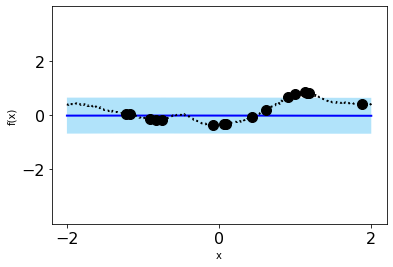

torch.Size([32, 17, 2])
torch.Size([32, 10, 2])
torch.Size([32, 3, 2])
torch.Size([32, 17, 2])
torch.Size([32, 12, 2])
torch.Size([32, 3, 2])
torch.Size([32, 9, 2])
torch.Size([32, 8, 2])
torch.Size([32, 3, 2])
torch.Size([32, 6, 2])
torch.Size([32, 5, 2])
torch.Size([32, 5, 2])
torch.Size([32, 16, 2])
torch.Size([32, 7, 2])
torch.Size([32, 3, 2])
torch.Size([32, 22, 2])
torch.Size([32, 4, 2])
torch.Size([32, 19, 2])
torch.Size([32, 10, 2])
torch.Size([32, 5, 2])
torch.Size([32, 18, 2])
torch.Size([32, 4, 2])
torch.Size([32, 8, 2])
torch.Size([32, 24, 2])
torch.Size([32, 4, 2])
torch.Size([32, 15, 2])
torch.Size([32, 17, 2])
torch.Size([32, 17, 2])
torch.Size([32, 22, 2])
torch.Size([32, 4, 2])
torch.Size([32, 4, 2])
torch.Size([32, 19, 2])
torch.Size([32, 21, 2])
torch.Size([32, 4, 2])
torch.Size([32, 10, 2])
torch.Size([32, 8, 2])
torch.Size([32, 21, 2])
torch.Size([32, 8, 2])
torch.Size([32, 20, 2])
torch.Size([32, 16, 2])
torch.Size([32, 8, 2])
torch.Size([32, 3, 2])
torch.Size([32

torch.Size([32, 13, 2])
torch.Size([32, 3, 2])
torch.Size([32, 6, 2])
torch.Size([32, 3, 2])
torch.Size([32, 3, 2])
torch.Size([32, 6, 2])
torch.Size([32, 6, 2])
torch.Size([32, 5, 2])
torch.Size([32, 22, 2])
torch.Size([32, 13, 2])
torch.Size([32, 7, 2])
torch.Size([32, 21, 2])
torch.Size([32, 3, 2])
torch.Size([32, 14, 2])
torch.Size([32, 30, 2])
torch.Size([32, 3, 2])
torch.Size([32, 7, 2])
torch.Size([32, 24, 2])
torch.Size([32, 3, 2])
torch.Size([32, 12, 2])
torch.Size([32, 5, 2])
torch.Size([32, 8, 2])
torch.Size([32, 17, 2])
torch.Size([32, 5, 2])
torch.Size([32, 5, 2])
torch.Size([32, 12, 2])
torch.Size([32, 5, 2])
torch.Size([32, 16, 2])
torch.Size([32, 3, 2])
torch.Size([32, 11, 2])
torch.Size([32, 12, 2])
torch.Size([32, 9, 2])
torch.Size([32, 13, 2])
torch.Size([32, 6, 2])
torch.Size([32, 8, 2])
torch.Size([32, 11, 2])
torch.Size([32, 10, 2])
torch.Size([32, 7, 2])
torch.Size([32, 3, 2])
torch.Size([32, 3, 2])
torch.Size([32, 21, 2])
torch.Size([32, 19, 2])
torch.Size([32, 

KeyboardInterrupt: 

In [19]:
for it in range(training_iterations):
    temperature = np.minimum(1, 2*it / training_iterations)
    data_train = dataset_train.generate_curves(log_sample=True, temperature=temperature)
    optimizer.zero_grad()
    log_prob, _, _ = CNPmodel(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    # print('Iteration: {}, train loss: {}'.format(it, loss))
    if it % PLOT_AFTER == 0:
        data_test = dataset_test.generate_curves(log_sample=True, temperature=temperature)
        test_log_prob, pred_y, sigma = CNPmodel(data_test.query, data_test.target_y)
        test_loss = -test_log_prob.mean()

        print("{}, Iteration: {}, test loss: {}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss)
        )
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.cpu().detach().numpy(),
            data_test.target_y.cpu().detach().numpy(),
            context_x.cpu().detach().numpy(),
            context_y.cpu().detach().numpy(),
            pred_y.cpu().detach().numpy(),
            sigma.cpu().detach().numpy(),
        )

-----------------------------------------

# Relational Conditional Neural Processes

Relational Conditional Neural Processes (RCNPs) exploit a **relational encoding** to induce invariances in the network.

### Relational encoding

Assume we have a context set $(\mathbf{x}_i,\mathbf{y}_i)_{i=1}^n$ and we want to encode the datapoint $\mathbf{x}^\star$ (which may be part of the context or target set). The key idea is to *encode each data point based on how it relates to the entire context set*.

The relational encoding is defined as:
$$
\rho(\mathbf{x}^\star) = \bigoplus_{i=1}^n h_\theta( g(\mathbf{x}^\star, \mathbf{x}_i), \mathbf{y}_i )
$$
where:
- $g: \mathbb{R}^{d_\text{x}} \times \mathbb{R}^{d_\text{x}} \rightarrow \mathbb{R}^{d_\text{comp}}$ is the **comparison function** that specifies how a pair $\mathbf{x}_i, \mathbf{x}^\star$ should be compared ($d_\text{x}$ is the dimensionality of the input, and $d_\text{comp}$ the dimensionality of the output of the comparison). This function should get rid of all information that does not matter. For example, if we want to encode translational invariance, the comparison function should be the difference of the inputs, $g(\mathbf{x}_i, \mathbf{x}^\star) = \mathbf{x}^\star - \mathbf{x}_i$ (with $d_\text{comp} = d_\text{x}$). Similarly, isotropy (invariance to rigid transformations, i.e. rotations, translations, and mirroring) can be encoded by using as comparison function the Euclidean distance $g(\mathbf{x}_i, \mathbf{x}^\star) = ||\mathbf{x}_i - \mathbf{x}^\star||$ (with $d_\text{comp} = 1$).
- $h_\theta: \mathbb{R}^{d_\text{comp}} \times \mathbb{R}^{d_\text{y}} \rightarrow \mathbb{R}^{d_\text{rel}}$ is the **relational encoding network**, a neural network that takes a comparison vector and the reference output value $y_i \in \mathbb{R}^{d_\text{y}}$ and maps into a high-dimensional space ($\mathbb{R}^{d_\text{rel}}$).
- $\bigoplus$ is a commutative aggregate function, like sum or mean, to enforce permutation invariance of relational encoding with respect to the ordering of the set of context points.
- The relational encoding of data point $\mathbf{x}^\star$ is $\rho(\mathbf{x}^\star)$. As desired, each data point is encoded based on how it relates to the entire context set. Note that context sets are typically of smallish size (up to a hundred data points), so this form of encoding is not particularly expensive.

Below we write a relational encoder for translational invariance.

In [12]:
class RelationalEncoder(nn.Module):
    def __init__(self, sizes):
        super(RelationalEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y, target_x):
        """
        Encode target point as relational representation with the context set.

        Args:
            context_x:  batch_size x set_size x feature_dim
            context_y:  batch_size x set_size x 1
            target_x:   batch_size x target_set_size x feature_dim

        Returns:
            encoded_target_x: batch_size x target_set_size x relational_dim
        """
        
        out_dim = 1
        batch_size, set_size, feature_dim = context_x.shape
        _, target_set_size, _ = target_x.shape
        
        # Compute difference between target and context set 
        # (we also concatenate y_i to the context, and 0 for the target)
        context_xp = torch.cat((context_x, context_y), dim=-1).unsqueeze(1)
        target_xp = torch.cat((target_x, torch.zeros(batch_size,target_set_size,1,device=device)), dim=-1).unsqueeze(2)
        diff_x = (target_xp - context_xp).reshape(batch_size,-1,feature_dim + out_dim)
        
        batch_size, diff_size, filter_size = diff_x.shape
        x = diff_x.view(batch_size * diff_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, diff_size, -1)
        
        encoded_feature_dim = x.shape[-1]
        
        x = torch.reshape(x,(batch_size, target_set_size, set_size, encoded_feature_dim))
        encoded_target_x = x.mean(dim=2).squeeze()
        
        return encoded_target_x

### Encoder and decoder

The encoder and decoder in RCNPs are exactly the same as in CNPs, with the only difference that they take as input the *relationally encoded* context or target points.

### Model

The RCNP model is very similar to the standard CNP model, it just needs to apply the relational encoder as needed to encode the context and target sets.

In [13]:
class RCNPDeterministicModel(nn.Module):
    def __init__(self, relational_sizes, encoder_sizes, decoder_sizes):
        super(RCNPDeterministicModel, self).__init__()
        self._relational_encoder = RelationalEncoder(relational_sizes)
        self._encoder = CNPDeterministicEncoder(encoder_sizes)
        self._decoder = CNPDeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        encoded_context_x = self._relational_encoder(context_x,context_y,context_x)
        representation = self._encoder(encoded_context_x, context_y)        
        encoded_target_x = self._relational_encoder(context_x,context_y,target_x)        
        dist, mu, sigma = self._decoder(representation, encoded_target_x)

        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

## Running Relational Conditional Neural Processes

Now that we have defined the RCNP model and its components we can train and run it, exactly as we did before for standard CNPs.

In [14]:
training_iterations = TRAINING_ITERATIONS if train_RCNP else 0

torch.manual_seed(0)
# Train dataset
dataset_train = GPCurvesReader(batch_size=32, max_num_context=MAX_CONTEXT_POINTS)
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=32, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
d_x, d_in, representation_size, relational_size, d_out = 1, 2, 128, 64, 2
relational_sizes = [d_in, 128, 128, relational_size]
encoder_sizes = [relational_size + 1, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + relational_size, 128, 128, 2]

model = RCNPDeterministicModel(relational_sizes, encoder_sizes, decoder_sizes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

2023-03-31 13:38:01, Iteration: 0, test loss: 0.7097480893135071


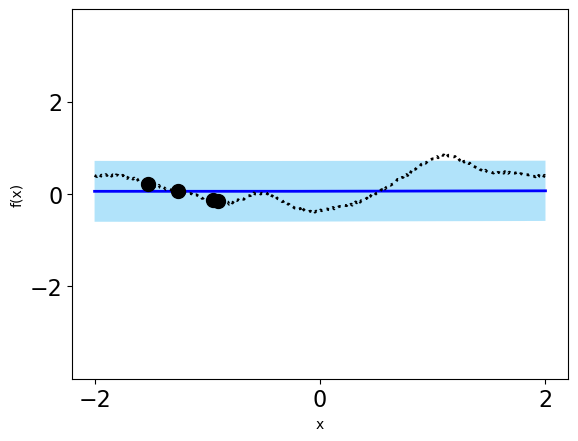

2023-03-31 13:38:55, Iteration: 2000, test loss: -0.019581938162446022


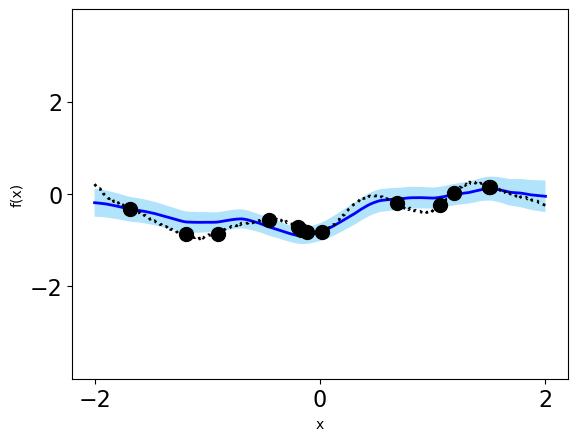

2023-03-31 13:39:49, Iteration: 4000, test loss: 0.492733895778656


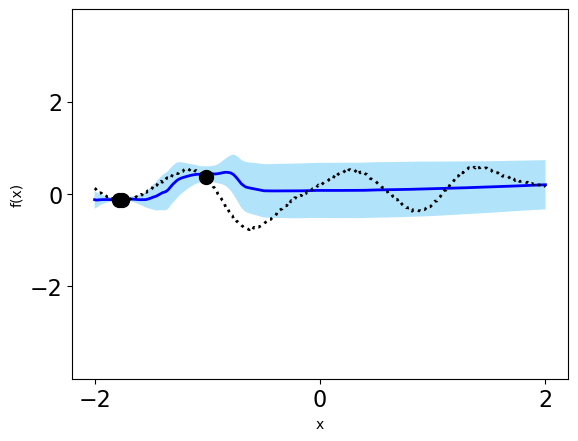

2023-03-31 13:40:48, Iteration: 6000, test loss: -0.29374799132347107


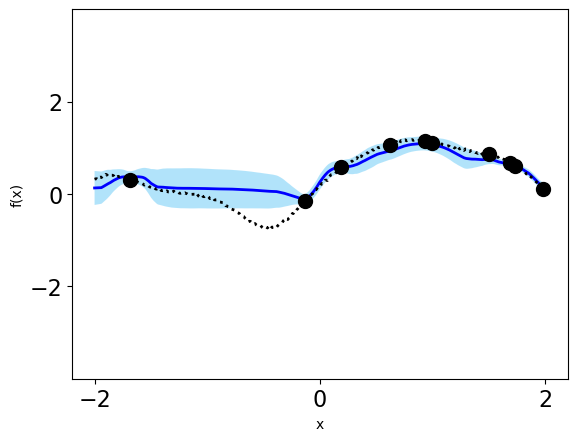

2023-03-31 13:41:44, Iteration: 8000, test loss: -0.7485072016716003


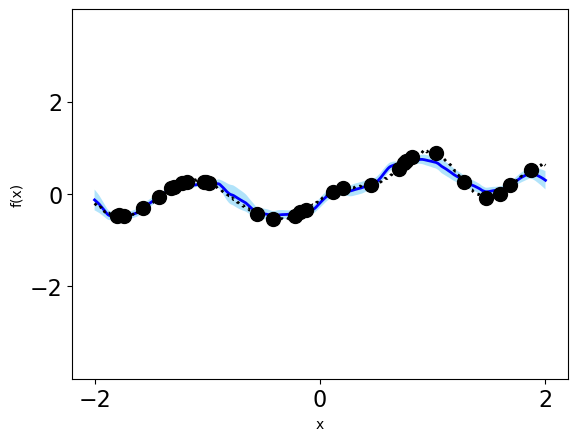

2023-03-31 13:42:40, Iteration: 10000, test loss: 0.19425223767757416


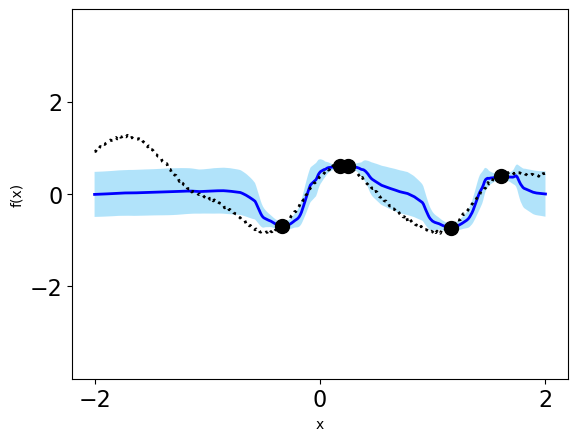

2023-03-31 13:43:37, Iteration: 12000, test loss: -0.4400668144226074


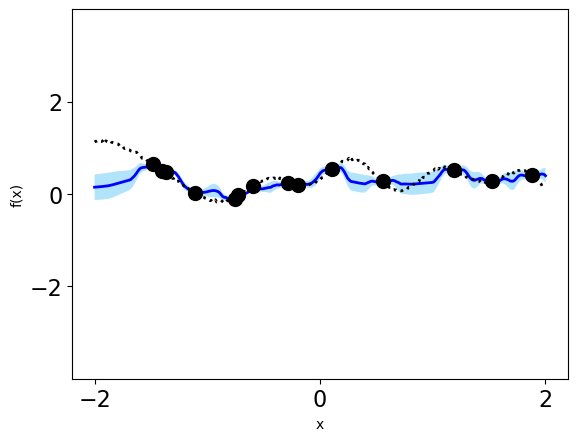

2023-03-31 13:44:33, Iteration: 14000, test loss: 0.27807480096817017


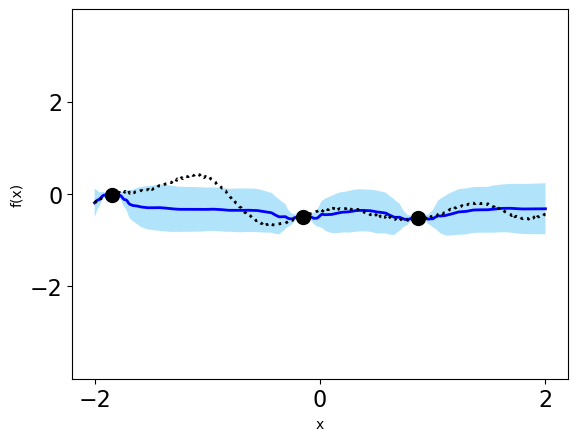

2023-03-31 13:45:27, Iteration: 16000, test loss: -0.4884265065193176


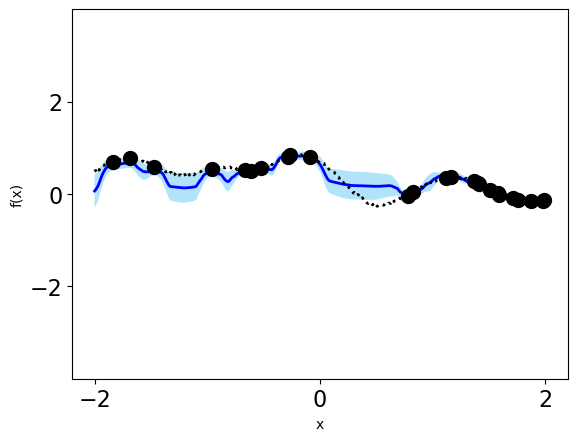

2023-03-31 13:46:21, Iteration: 18000, test loss: -0.5240174531936646


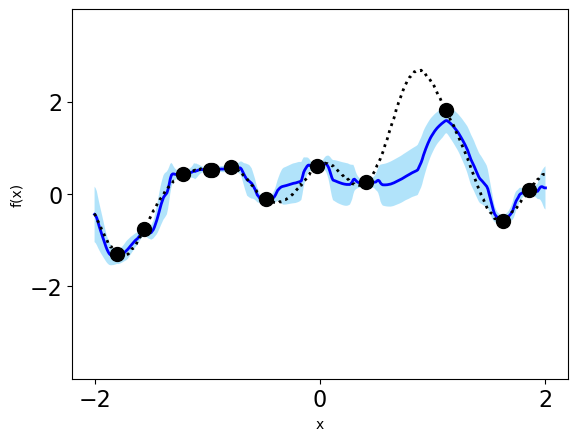

2023-03-31 13:47:19, Iteration: 20000, test loss: -0.6451277732849121


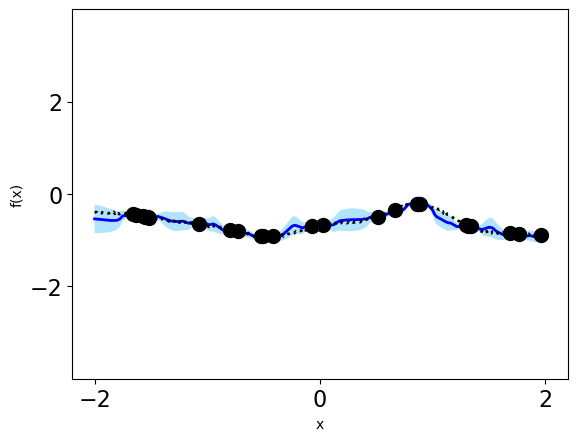

2023-03-31 13:48:14, Iteration: 22000, test loss: -0.4343896508216858


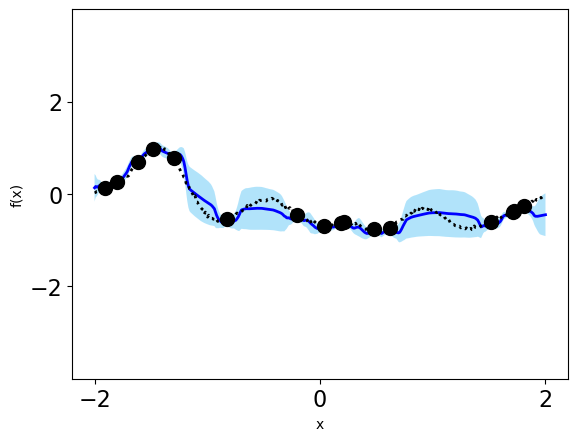

2023-03-31 13:49:10, Iteration: 24000, test loss: 0.030471758916974068


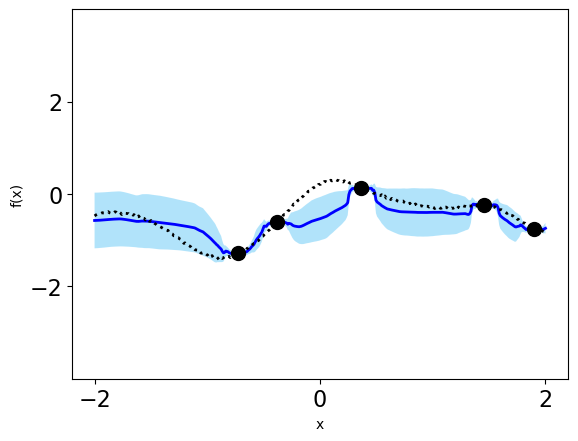

2023-03-31 13:50:05, Iteration: 26000, test loss: 0.5781676173210144


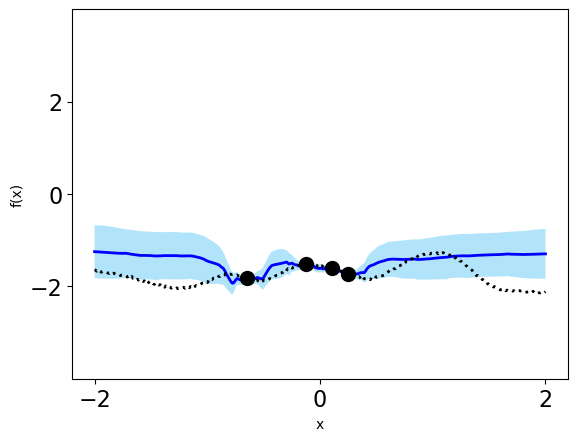

2023-03-31 13:51:03, Iteration: 28000, test loss: -0.08859577029943466


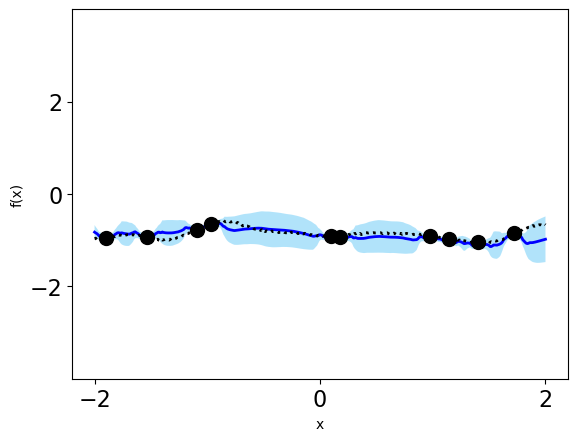

2023-03-31 13:52:00, Iteration: 30000, test loss: 0.1458115428686142


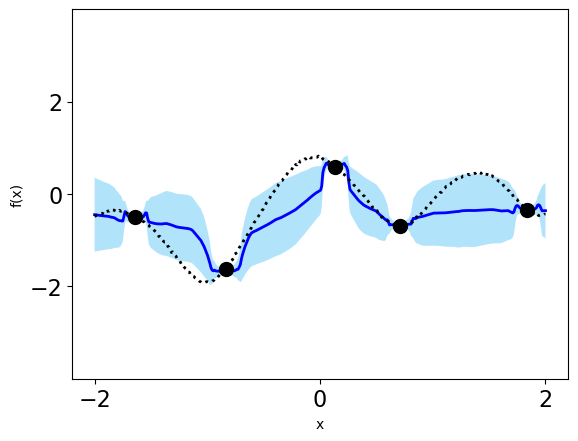

2023-03-31 13:52:57, Iteration: 32000, test loss: 0.2443443238735199


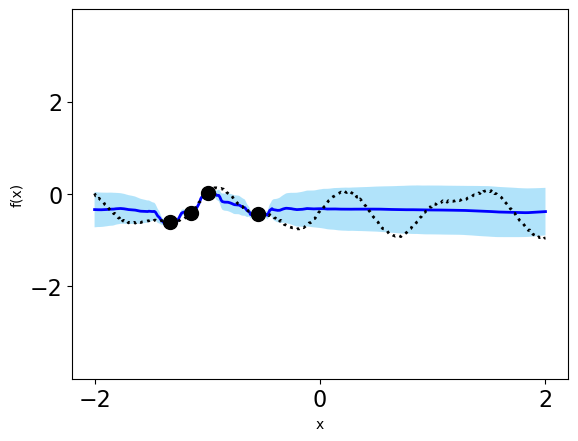

2023-03-31 13:53:55, Iteration: 34000, test loss: 0.31473398208618164


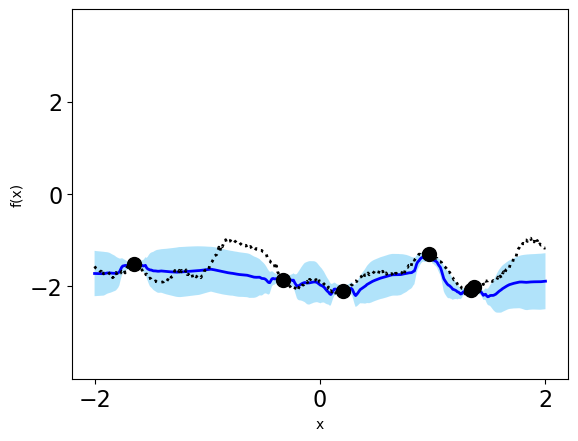

2023-03-31 13:54:50, Iteration: 36000, test loss: 0.304768830537796


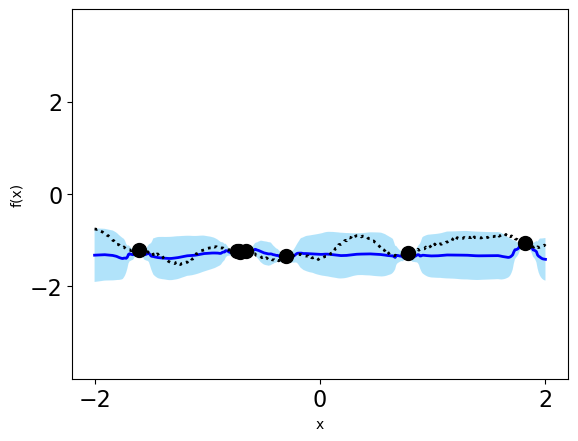

2023-03-31 13:55:47, Iteration: 38000, test loss: 0.18081457912921906


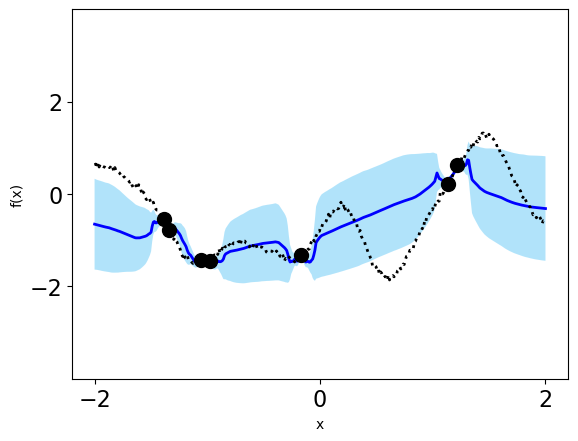

2023-03-31 13:56:43, Iteration: 40000, test loss: 0.08310536295175552


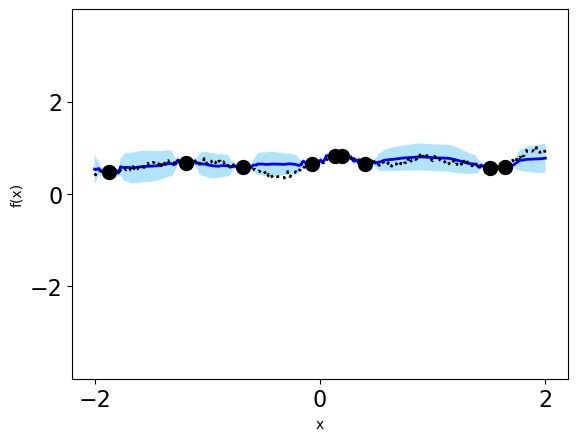

2023-03-31 13:57:38, Iteration: 42000, test loss: 0.31443294882774353


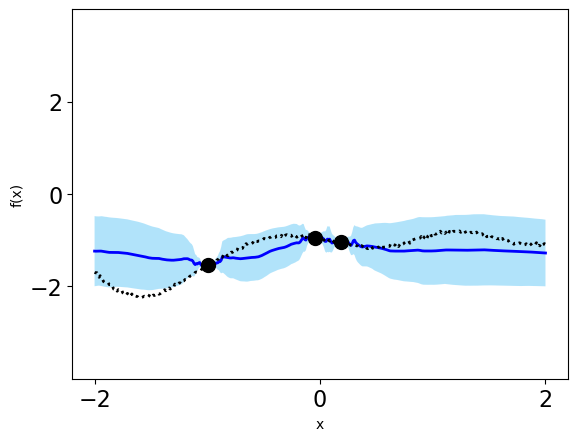

2023-03-31 13:58:31, Iteration: 44000, test loss: 0.49148809909820557


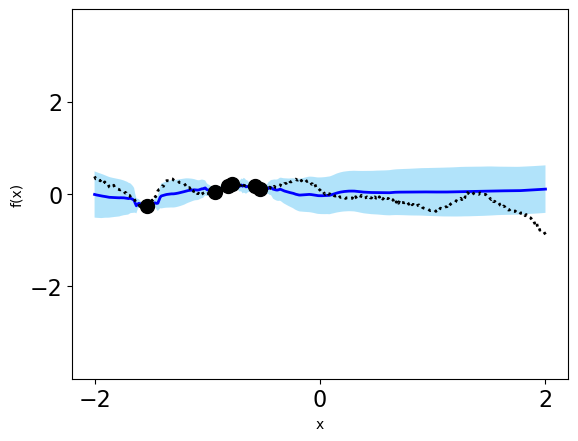

2023-03-31 13:59:26, Iteration: 46000, test loss: -0.536802351474762


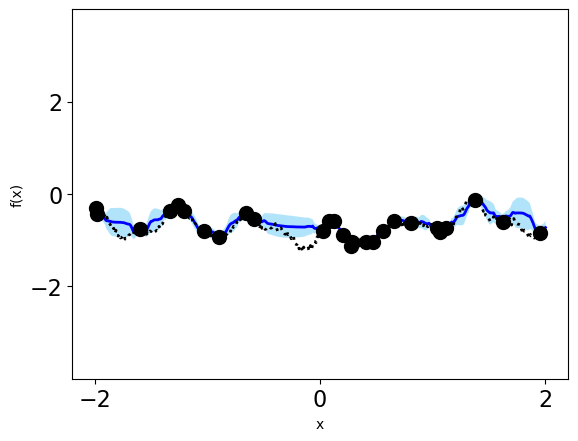

2023-03-31 14:00:22, Iteration: 48000, test loss: 0.055906254798173904


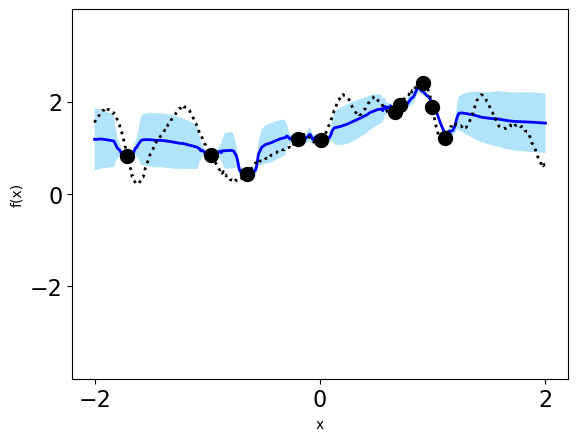

2023-03-31 14:01:17, Iteration: 50000, test loss: 0.5769780278205872


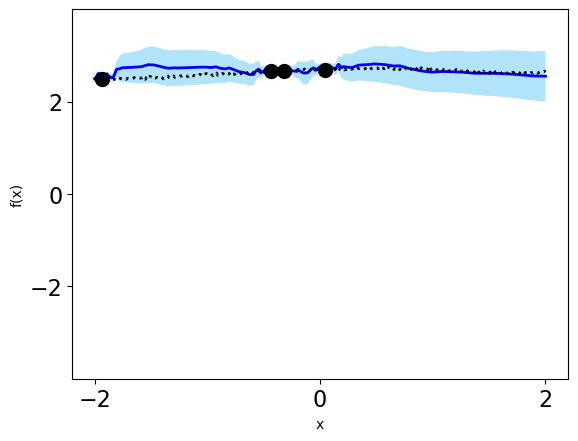

2023-03-31 14:02:12, Iteration: 52000, test loss: -0.2967612147331238


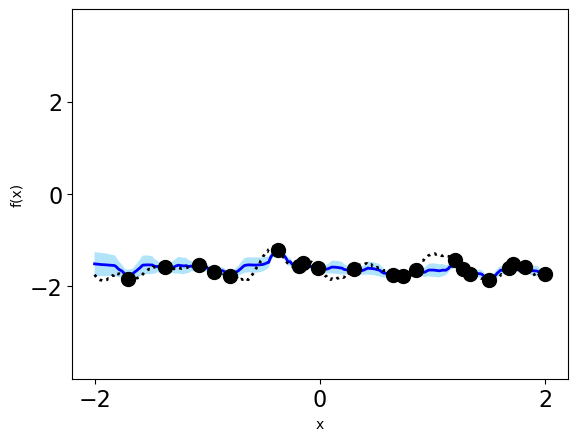

2023-03-31 14:03:07, Iteration: 54000, test loss: -0.4179799556732178


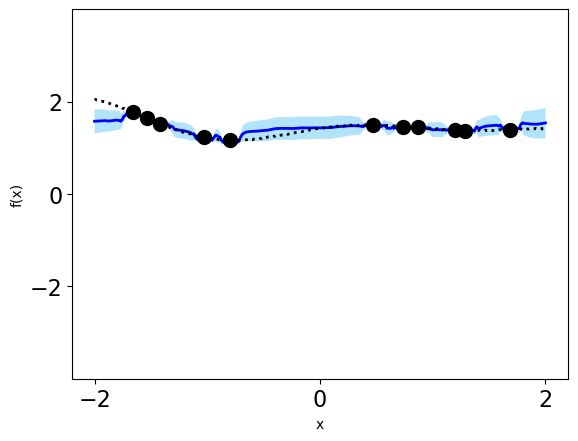

2023-03-31 14:04:00, Iteration: 56000, test loss: 0.006629054434597492


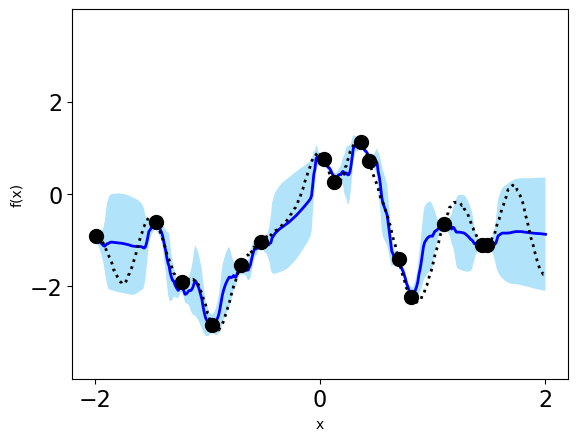

2023-03-31 14:04:54, Iteration: 58000, test loss: 0.684501051902771


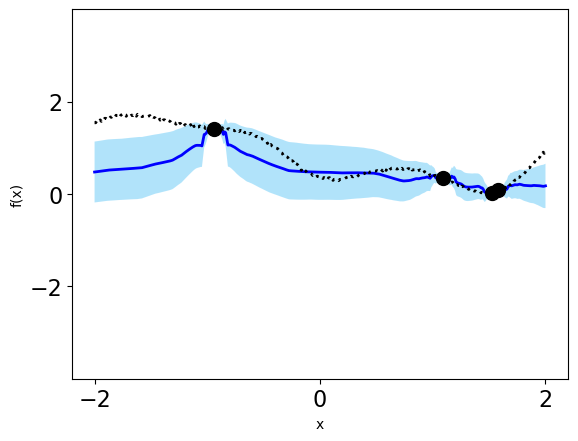

2023-03-31 14:05:49, Iteration: 60000, test loss: -0.6798461675643921


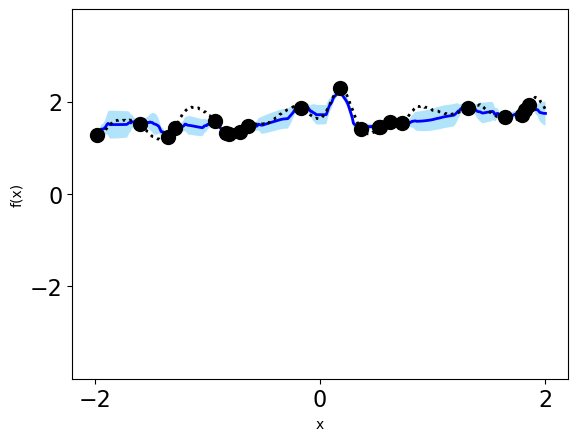

2023-03-31 14:06:42, Iteration: 62000, test loss: -0.287004679441452


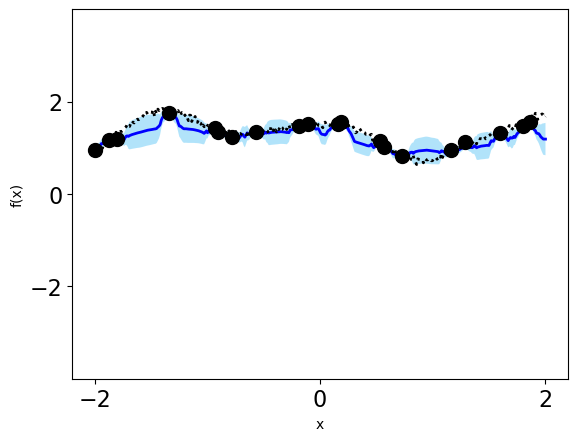

2023-03-31 14:07:37, Iteration: 64000, test loss: 0.1012917086482048


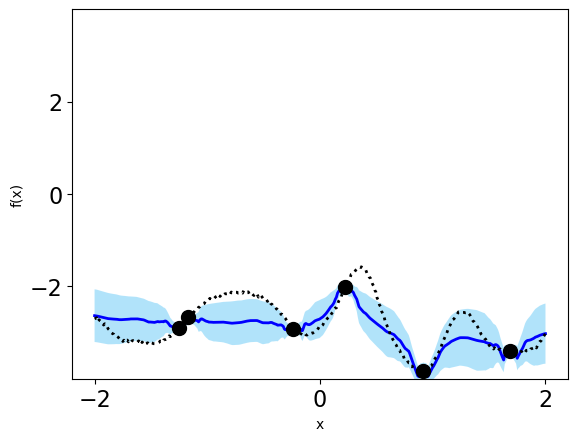

2023-03-31 14:08:31, Iteration: 66000, test loss: 0.2691316306591034


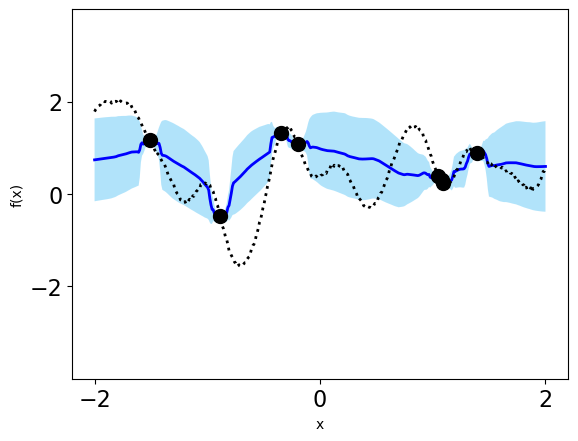

2023-03-31 14:09:26, Iteration: 68000, test loss: 0.12161680310964584


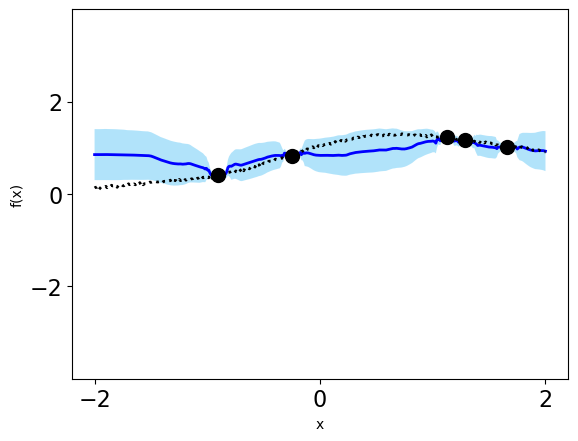

2023-03-31 14:10:22, Iteration: 70000, test loss: 0.7990437150001526


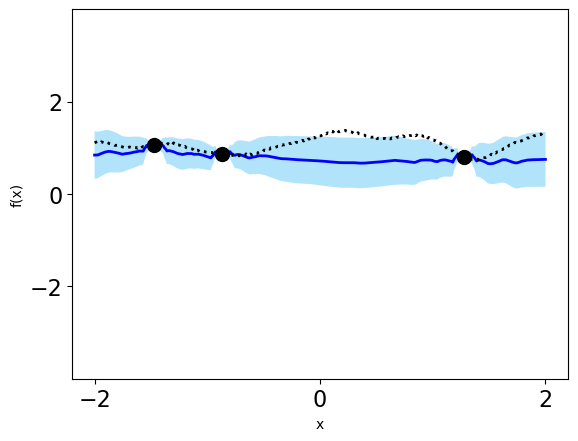

2023-03-31 14:11:17, Iteration: 72000, test loss: -0.40130001306533813


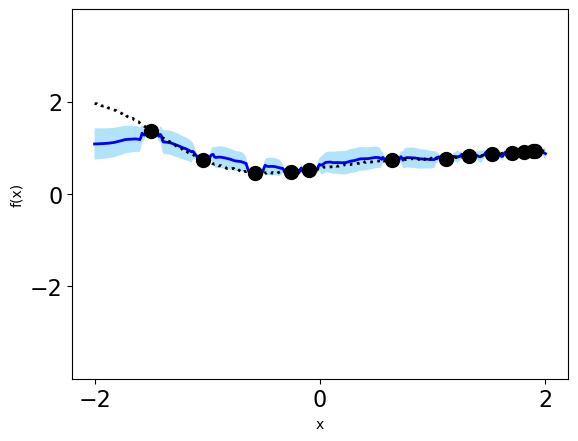

2023-03-31 14:12:12, Iteration: 74000, test loss: 0.4143105149269104


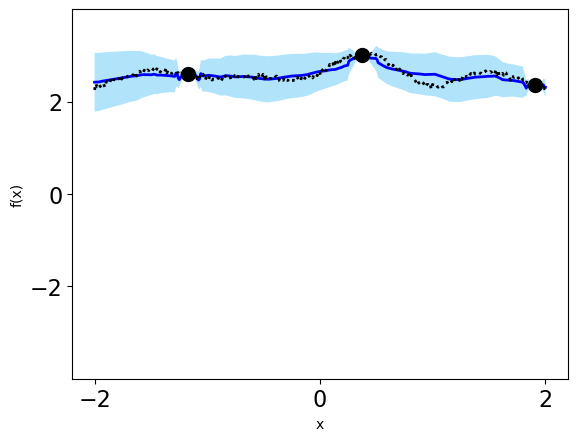

2023-03-31 14:13:09, Iteration: 76000, test loss: -0.3092579245567322


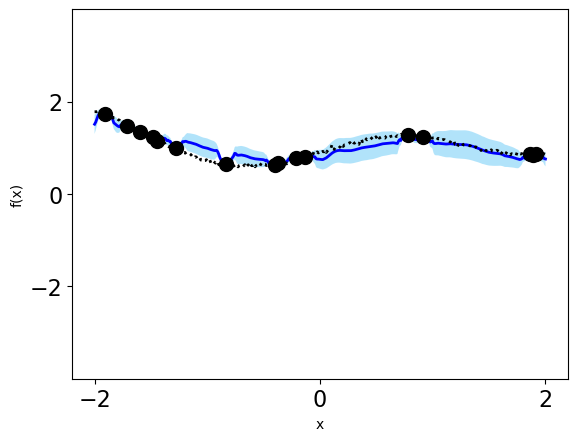

2023-03-31 14:14:04, Iteration: 78000, test loss: 0.45452070236206055


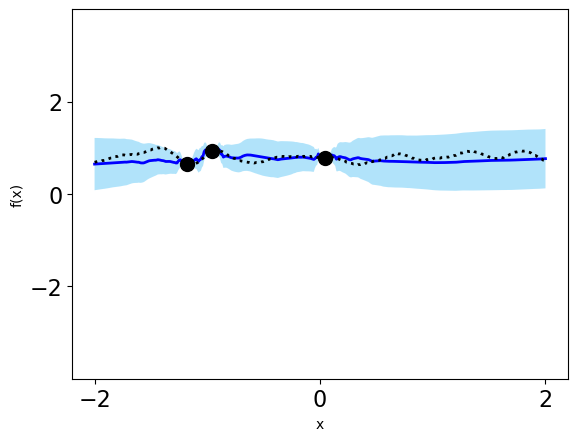

2023-03-31 14:15:05, Iteration: 80000, test loss: -0.04978121072053909


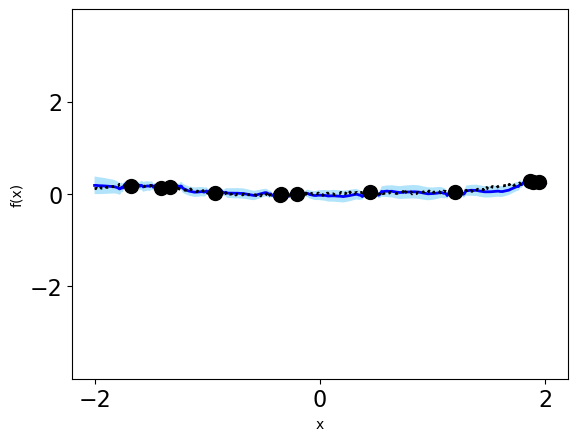

2023-03-31 14:16:03, Iteration: 82000, test loss: 0.2514239549636841


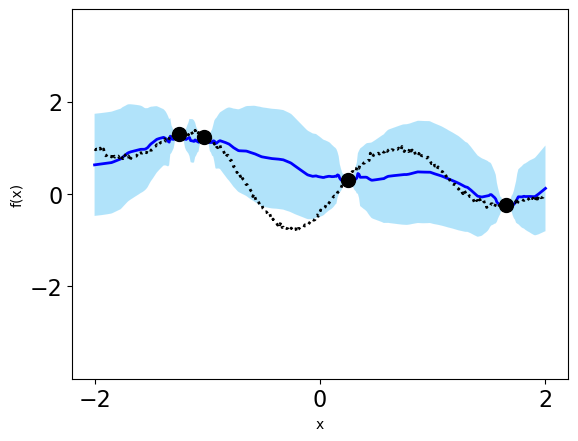

2023-03-31 14:17:00, Iteration: 84000, test loss: 0.8709745407104492


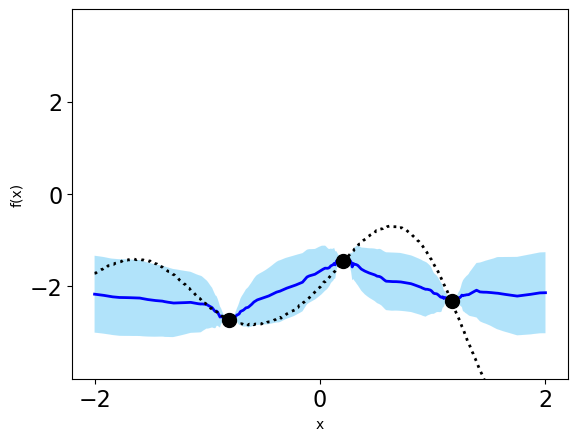

2023-03-31 14:18:01, Iteration: 86000, test loss: 0.359141081571579


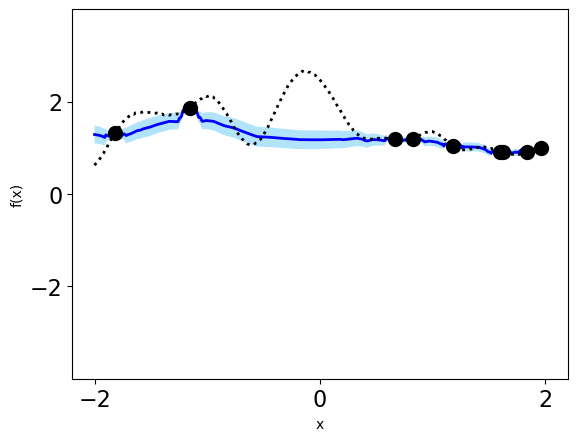

2023-03-31 14:19:05, Iteration: 88000, test loss: 0.18921692669391632


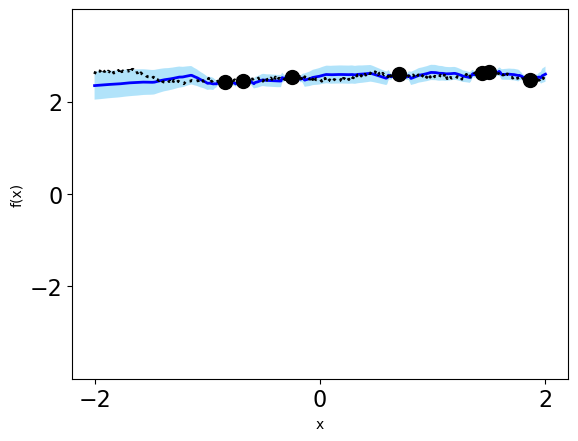

2023-03-31 14:20:02, Iteration: 90000, test loss: 0.5580214858055115


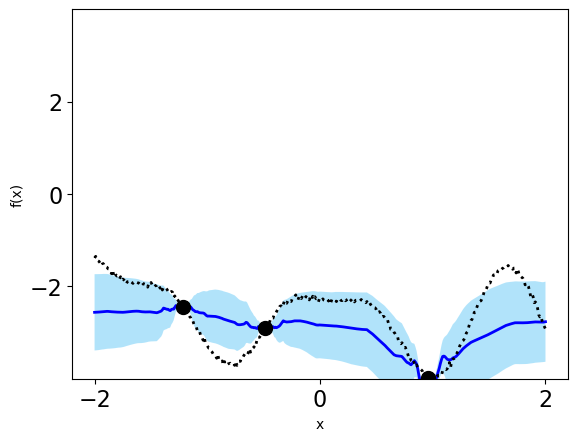

2023-03-31 14:21:10, Iteration: 92000, test loss: 0.43496179580688477


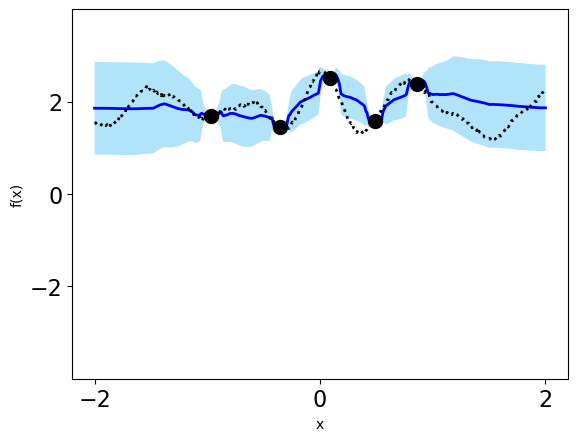

2023-03-31 14:22:14, Iteration: 94000, test loss: -0.5490289926528931


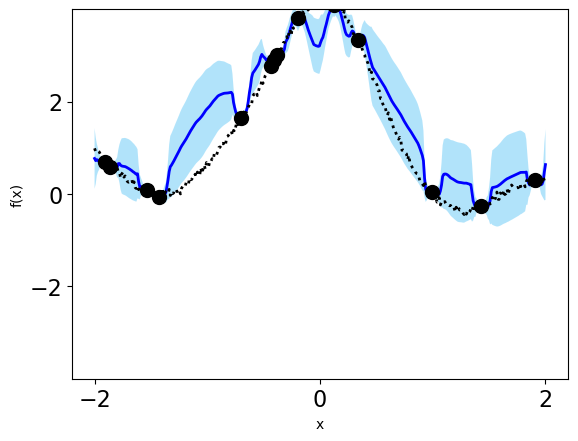

2023-03-31 14:23:10, Iteration: 96000, test loss: 0.19044198095798492


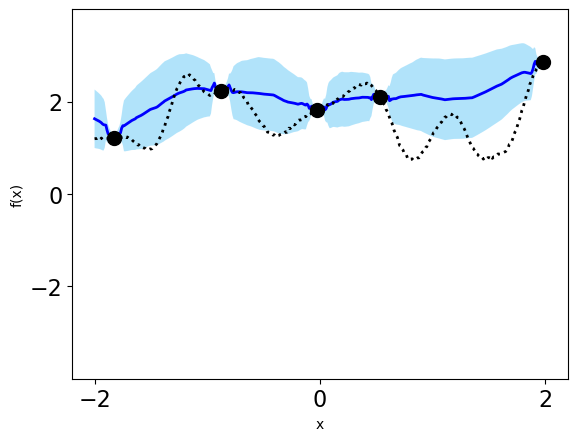

2023-03-31 14:24:16, Iteration: 98000, test loss: -0.7114695310592651


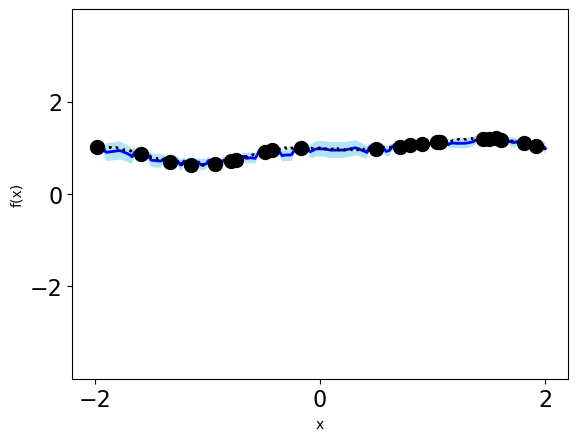

In [15]:
for it in range(training_iterations):
    temperature = np.minimum(1, 2*it / training_iterations)
    #temperature = 1
    
    data_train = dataset_train.generate_curves(temperature=temperature, log_sample=True)
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    # print('Iteration: {}, train loss: {}'.format(it, loss))
    if it % PLOT_AFTER == 0:
        data_test = dataset_test.generate_curves(temperature=temperature, log_sample=True)
        test_log_prob, pred_y, sigma = model(data_test.query, data_test.target_y)
        test_loss = -test_log_prob.mean()

        print("{}, Iteration: {}, test loss: {}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss)
        )
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.cpu().detach().numpy(),
            data_test.target_y.cpu().detach().numpy(),
            context_x.cpu().detach().numpy(),
            context_y.cpu().detach().numpy(),
            pred_y.cpu().detach().numpy(),
            sigma.cpu().detach().numpy(),
        )

## Comparison of CNP and RCNPs on out-of-distribution data

Below, we show what happens if we test the CNP and RCNP on an out-of-distribution scenario in which we shift everything outside the training set. 

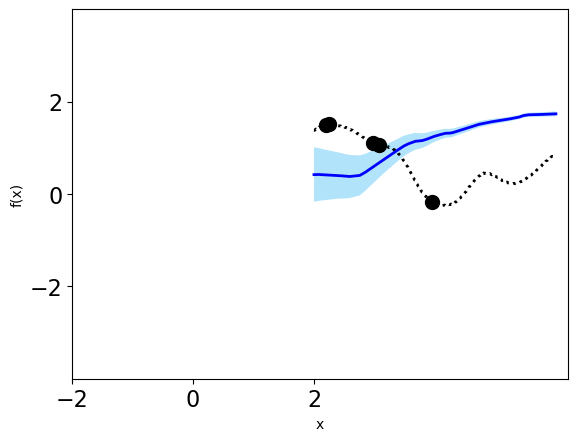

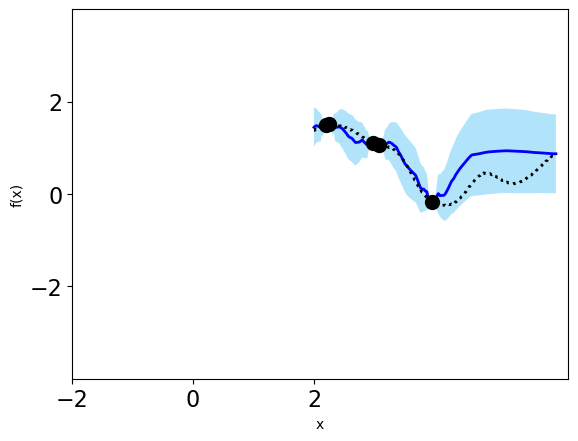

In [16]:
data_test = dataset_test.generate_curves(temperature=temperature, log_sample=True)
(context_x, context_y), target_x = data_test.query
target_y = data_test.target_y

context_x += 4
target_x += 4

query_shifted = ((context_x, context_y), target_x)
shifted_data_test = CNPRegressionDescription(query=query_shifted, target_y=target_y)

test_model = CNPmodel
est_log_prob, pred_y, sigma = test_model(data_test.query, data_test.target_y)

plot_functions(
            target_x.cpu().detach().numpy(),
            data_test.target_y.cpu().detach().numpy(),
            context_x.cpu().detach().numpy(),
            context_y.cpu().detach().numpy(),
            pred_y.cpu().detach().numpy(),
            sigma.cpu().detach().numpy(),
)

test_model = model
est_log_prob, pred_y, sigma = test_model(data_test.query, data_test.target_y)

plot_functions(
            target_x.cpu().detach().numpy(),
            data_test.target_y.cpu().detach().numpy(),
            context_x.cpu().detach().numpy(),
            context_y.cpu().detach().numpy(),
            pred_y.cpu().detach().numpy(),
            sigma.cpu().detach().numpy(),
)

# Discussion and remarks

- This method should extend relatively straighforwardly to Attentional Neural Processes (ANPs) and Gaussian Neural Processes (GNPs); we only need to use the relational encoding of a point instead of the original point, and this will ensure that invariances are preserved.
- The main disadvantage is that we are encoding each point relative to the full context set. Effectively, the cost at inference time becomes $O(mn)$, where $n$ is the size of the context set and $m$ the size of the target set, whereas the original CNPs have a $O(m)$ cost. However, if we compare with ConvCNPs, our method should do way better given their convoluted approach (pun intended). In particular, we should be able to easily scale to $D > 2$, which is a fairly low bar.
- Note that RCNPs do not "just" implement translational invariance: the fact that the architecture is translational invariant means that training is much more data-efficient thanks to the correct inductive bias (i.e., we are reducing the space of functions, making the learning task easier). You can see it (qualitatively) by comparing the plots of CNP and RCNP during training (we can then quantify it as well).
- The current implementation does not include *permutation invariance* in terms of input dimensions, which would be a desirable feature if we want to model GPs in $D > 2$. In other words, the output should not change if we permute all the indices of the inputs (both for the context and target set), since there is a priori no difference between different input dimensions (a posteriori there might be, as different input dimensions might have different input length scales, for example). Note that permutation invariance is not always true; for some problems the coordinates *are* different a priori.  Permutation equivariance (not invariance) is implemented in [this paper](https://github.com/PrincetonLIPS/AHGP) which we discussed, and perhaps we can do something similar. However, I have not thought about this yet.
